In [1]:
from project import Projection
from Problem import Problem
from main import run_experiment, load_config
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from utils import visualize_pareto_front

In [2]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math

In [3]:
case = "_Ex_7_2"

# Prob

In [4]:
def f1(x):    return (x[0]**2 + x[1]**2)/50
def f2(x):    return ((x[0] - 5)**2 + (x[1] - 5)**2)/50
def f(x):    return np.array([
    (x[0]**2 + x[1]**2)/50,
    ((x[0] - 5)**2 + (x[1] - 5)**2)/50])
#--------------- C --------------------#
bounds_x = Bounds([0,0],[5, 5])

#--------------- Q --------------------#
def q1(y):    return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2

def q_plus(y):
    center = 0.4
    radius_sq = 0.2**2  
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)
# Hàm dùng cho Projection 
cons_C = ()
dim_x = 2
cons_Q = ({'type': 'ineq', 'fun' : q1,},)
cons_Qplus = ({'type': 'ineq', 'fun': q_plus},)
dim_y = 2
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')
# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[],
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)
z_star = np.array([0.0, 0.0])
x_init = np.array([-10.0, -10.0])

# Config

In [26]:
from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq

def update_config(file_path, x_init_np):
    yaml = YAML()
    yaml.preserve_quotes = True
    yaml.indent(mapping=2, sequence=4, offset=2)

    with open(file_path, 'r', encoding='utf-8') as f_in:
        config = yaml.load(f_in)

    val_list = x_init_np.tolist() if hasattr(x_init_np, 'tolist') else x_init_np
    
    flow_list = CommentedSeq(val_list)
    flow_list.fa.set_flow_style() 

    config['initialization']['x_init'] = flow_list
    
    config['phase1']['gamma'] = 5
    config['phase1']['expo_gamma'] = 0.8
    config['phase1']['max_iter'] = 500
    
    config['phase2']['mu'] = 0.1
    config['phase2']['init_params'] = 1
    config['phase2']['expo_alpha'] = 0.35            
    config['phase2']['expo_lambda'] = 0.65
    config['phase2']['max_iter'] = 1000

    # 3. Ghi lại vào file
    with open(file_path, 'w', encoding='utf-8') as f_in:
        yaml.dump(config, f_in)
    
    print(f"✅ Đã cập nhật xong file: {file_path}")

# --- CHẠY THỬ ---
config_file = 'config.yaml'
update_config(config_file, x_init)

with open(config_file, 'r', encoding='utf-8') as f_in:
    print("\nNội dung file sau khi sửa:")
    print(f_in.read())

✅ Đã cập nhật xong file: config.yaml

Nội dung file sau khi sửa:
data:
  test_ray:
    -   - 1.0
        - 0.0
    -   - 0.9965844930066698
        - 0.08257934547233232
    -   - 0.9863613034027223
        - 0.1645945902807339
    -   - 0.9694002659393304
        - 0.24548548714079912
    -   - 0.9458172417006346
        - 0.32469946920468346
    -   - 0.9157733266550574
        - 0.4016954246529694
    -   - 0.8794737512064891
        - 0.4759473930370735
    -   - 0.8371664782625285
        - 0.5469481581224268
    -   - 0.7891405093963936
        - 0.6142127126896678
    -   - 0.7357239106731316
        - 0.677281571625741
    -   - 0.6772815716257411
        - 0.7357239106731316
    -   - 0.6142127126896678
        - 0.7891405093963936
    -   - 0.5469481581224269
        - 0.8371664782625285
    -   - 0.4759473930370736
        - 0.8794737512064891
    -   - 0.40169542465296953
        - 0.9157733266550574
    -   - 0.32469946920468357
        - 0.9458172417006346
    -   - 0.245

## Cloud

In [27]:
def generate_pareto_grid(f_func, c_funcs, q_plus_func, resolution=400):
    """
    Sinh dữ liệu Pareto cho bài toán 2D bằng cách quét lưới tọa độ.
    f_func: Hàm mục tiêu f(x)
    c_funcs: Danh sách các hàm ràng buộc c(x) >= 0 (miền C)
    q_plus_func: Hàm ràng buộc q_plus(y) >= 0 (miền Q+)
    """
    print(f"--- Đang quét lưới {resolution}x{resolution} điểm ---")
    
    # 1. Xác định phạm vi quét dựa trên các ràng buộc hình tròn c1, c2

    x0_range = np.linspace(0, 5, resolution)
    x1_range = np.linspace(0, 5, resolution)
    X0, X1 = np.meshgrid(x0_range, x1_range)
    
    # Làm phẳng để tính toán vector
    points_X = np.vstack([X0.ravel(), X1.ravel()]).T
    
    # 2. Kiểm tra ràng buộc miền C: c1(x) >= 0 và c2(x) >= 0
    # (Sử dụng các hàm c1, c2 đã định nghĩa của bạn)
    mask_C = np.ones(len(points_X), dtype=bool)
    for c_func in c_funcs:
        mask_C &= (c_func(points_X.T) >= 0)
    
    feasible_X = points_X[mask_C]
    print(f"-> Tìm thấy {len(feasible_X)} điểm thỏa mãn miền C.")
    
    if len(feasible_X) == 0:
        return None, None

    # 3. Tính giá trị mục tiêu f(x) và kiểm tra miền Q+
    f_vals = np.array([f_func(x) for x in feasible_X])  # shape (N, 2)
    
    # Kiểm tra q_plus(f(x)) >= 0
    # Lưu ý: Hàm q_plus của bạn nhận 1 vector y, ta cần áp dụng cho toàn bộ f_vals
    mask_Qplus = np.array([q_plus_func(y) >= 0 for y in f_vals])
    
    pf_cloud_data = f_vals[mask_Qplus]
    print(f"-> Lọc còn {len(pf_cloud_data)} điểm thỏa mãn Q+ (Cloud).")

    if len(pf_cloud_data) == 0:
        return None, None

    # 4. Lọc Pareto Front từ Cloud (Tìm các điểm không bị trội)
    # Sắp xếp theo f1 tăng dần
    sorted_indices = np.argsort(pf_cloud_data[:, 0])
    y_sorted = pf_cloud_data[sorted_indices]
    
    pareto_list = []
    pareto_list.append(y_sorted[0])
    current_min_f2 = y_sorted[0][1]
    
    for i in range(1, len(y_sorted)):
        if y_sorted[i][1] < current_min_f2:
            pareto_list.append(y_sorted[i])
            current_min_f2 = y_sorted[i][1]
    
    pf_targets_data = np.array(pareto_list)
    print(f"-> Kết quả: {len(pf_targets_data)} điểm Pareto.")
    
    return pf_cloud_data, pf_targets_data


In [28]:
# def non_c(x):
#     return 1
# pf_cloud, pf_targets = generate_pareto_grid(
#     f_func=f, 
#     c_funcs=[non_c], 
#     q_plus_func=q_plus, 
#     resolution=500
# )

# Project

In [29]:
results = run_experiment(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===
Khởi tạo: x0: [-10. -10.]
Chiếu lên C được: x: [0. 0.]


100%|██████████| 500/500 [00:03<00:00, 158.81it/s]


+-----+----------------------+---------+----------------------+----------------------+----------+----------+
|  k  | x_new                | gamma_k | y                    | z_proj               |   e_x    |   e_f    |
+-----+----------------------+---------+----------------------+----------------------+----------+----------+
|  0  | [0., 0.]             | 5.0000  | [0., 1.]             | [0. , 0.6]           | 0.565685 | 0.400000 |
|  10 | [0.796875, 0.796875] | 0.7343  | [0.0254 , 0.70665]   | [0.0254, 0.6   ]     | 0.018619 | 0.106650 |
|  20 | [0.885176, 0.885176] | 0.4377  | [0.031341, 0.677271] | [0.031341, 0.6     ] | 0.007873 | 0.077271 |
|  30 | [0.928898, 0.928898] | 0.3205  | [0.034514, 0.662955] | [0.034514, 0.600001] | 0.004647 | 0.062954 |
|  40 | [0.956485, 0.956485] | 0.2563  | [0.036595, 0.654001] | [0.036595, 0.600001] | 0.003166 | 0.053999 |
|  50 | [0.975988, 0.975988] | 0.2152  | [0.038102, 0.647707] | [0.038102, 0.600001] | 0.002337 | 0.047706 |
|  60 | [0.990734, 

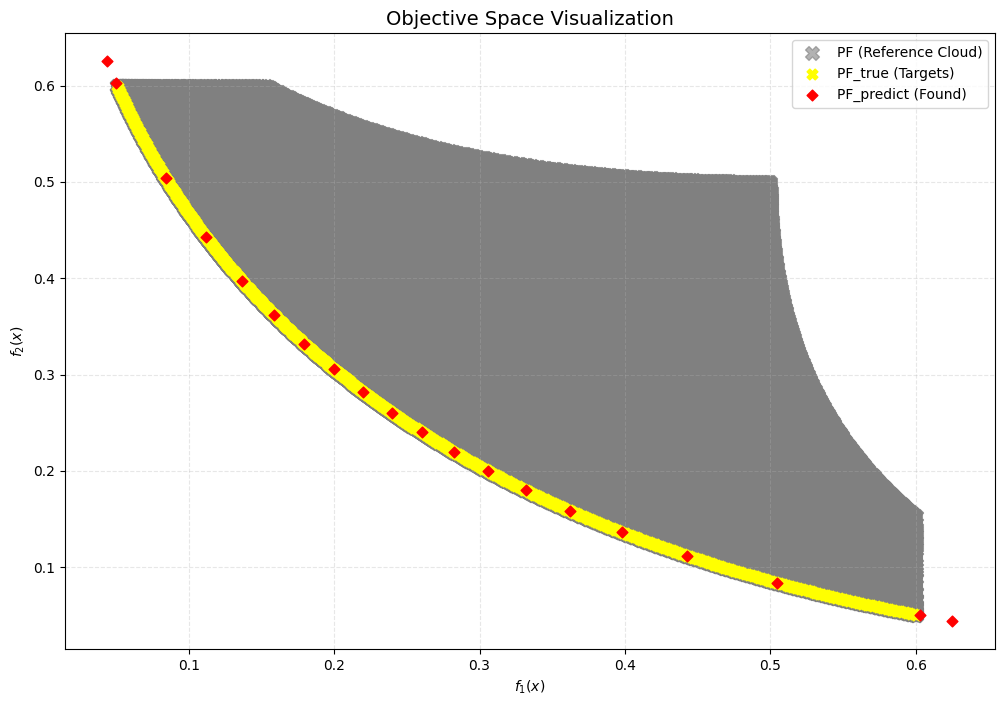

In [30]:
visualize_pareto_front(
    pf_pred=results["pareto_f"], 
    pf_cloud=pf_cloud,   
    pf_targets=pf_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

In [31]:
np.save(f"test/{case}/pf_true.npy", results["pareto_f"])
np.save(f"test/{case}/target_space.npy", pf_cloud)

# Dynamic

In [32]:
from main_dynamic import run_experiment as run_experiment_dynamic

In [33]:
results_dynamic = run_experiment_dynamic(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===
Khởi tạo: x0: [-10. -10.]
Chiếu lên C được: x: [0. 0.]


100%|██████████| 500/500 [00:03<00:00, 156.71it/s]


+-----+----------------------+---------+----------------------+----------------------+----------+----------+
|  k  | x_new                | gamma_k | y                    | z_proj               |   e_x    |   e_f    |
+-----+----------------------+---------+----------------------+----------------------+----------+----------+
|  0  | [0., 0.]             | 5.0000  | [0., 1.]             | [0. , 0.6]           | 0.565685 | 0.400000 |
|  10 | [0.796875, 0.796875] | 0.7343  | [0.0254 , 0.70665]   | [0.0254, 0.6   ]     | 0.018619 | 0.106650 |
|  20 | [0.885176, 0.885176] | 0.4377  | [0.031341, 0.677271] | [0.031341, 0.600001] | 0.007873 | 0.077270 |
|  30 | [0.928898, 0.928898] | 0.3205  | [0.034514, 0.662955] | [0.034514, 0.6     ] | 0.004647 | 0.062955 |
|  40 | [0.956485, 0.956485] | 0.2563  | [0.036595, 0.654001] | [0.036595, 0.6     ] | 0.003166 | 0.054001 |
|  50 | [0.975988, 0.975988] | 0.2152  | [0.038102, 0.647707] | [0.038102, 0.6     ] | 0.002337 | 0.047707 |
|  60 | [0.990734, 

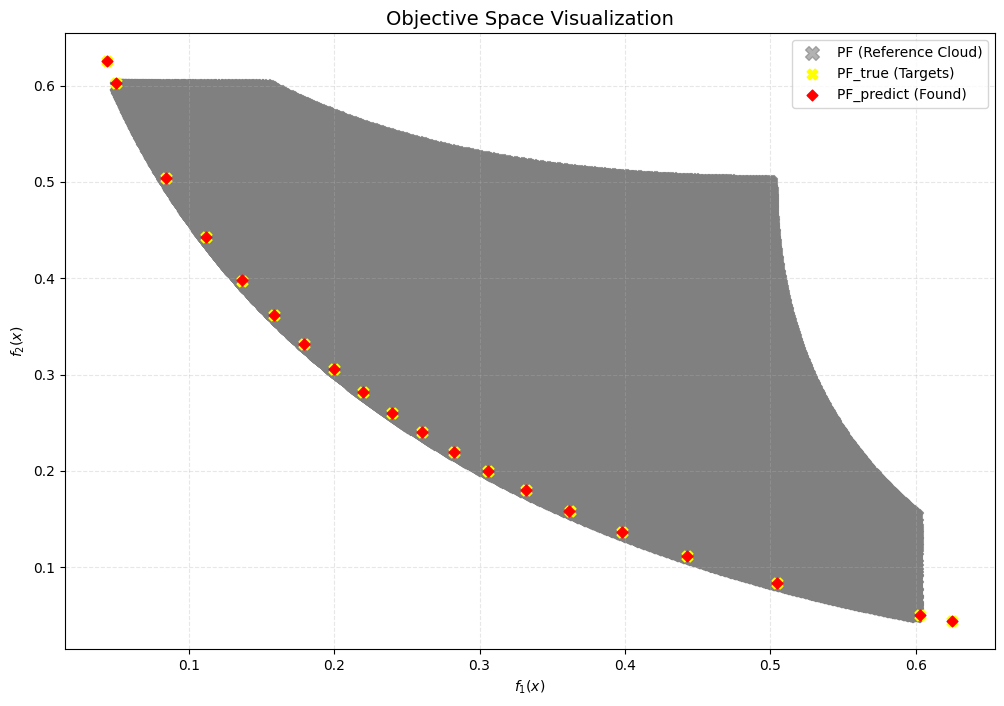

In [34]:
visualize_pareto_front(
    pf_pred=results_dynamic["pareto_f"], 
    pf_cloud=pf_cloud,   
    pf_targets=results["pareto_f"],
    title="Objective Space Visualization",
    figsize=(12, 8)
)

In [35]:
np.save(f"test/{case}/pf_dynamic_true.npy", results_dynamic["pareto_f"])